In [1]:
import os
import pandas as pd
import numpy as np
import math
import random
from IPython.core.debugger import Tracer
import warnings
warnings.filterwarnings("ignore")

LEFT = "LEFT" #0
RIGHT = "RIGHT" #1
UP = "UP" #2
DOWN = "DOWN" #3
MOVES = [LEFT, RIGHT, UP, DOWN]
MOVE = {LEFT : (0, -1), RIGHT : (0, 1), UP : (-1, 0), DOWN : (1, 0)}
CURRENT_CELL = 1
BLOCKED_CELL = -1
EMPTY_CELL = 0
GRID_SIZE = 6
N_CLASSES = 4

LEARNING_RATE = 0.01
Q_DISCOUNT_FACTOR = 0.9
Q_LEARNING_RATE = 0.9
Q_EXPLORATION_PROBABILITY = 0.75

REWARD_DEPRATION_RATE = 0.9
REWARD_FACTOR = 2

dp = {}

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import LabelBinarizer
import keras.backend as K

model = None
BATCH_SIZE = 1
FEATURE_SIZE = GRID_SIZE * GRID_SIZE
n_classes = N_CLASSES
EPOCHS = 15


def customLoss(yTrue,yPred):
    return K.sum(K.abs(yTrue - yPred))


def get_features(grid):
    return np.int32([grid.flatten()])

def search_grid(grid, val):
    loc = np.where(grid == val)
    return (loc[0][0], loc[1][0])


def validate_move(grid, current_loc, move):
    grid = grid.copy()
    next_loc = (current_loc[0] + move[0], current_loc[1] + move[1])
    
    if next_loc[0] < 0 or next_loc[1] < 0 or next_loc[0] == len(grid) or next_loc[1] == len(grid):
        return False, current_loc, grid
    
    if grid[next_loc[0]][next_loc[1]] != EMPTY_CELL:
        return False, current_loc, grid
    
    grid[current_loc[0]][current_loc[1]] = BLOCKED_CELL
    grid[next_loc[0]][next_loc[1]] = CURRENT_CELL
    return True, next_loc, grid


def get_model(feature_size=FEATURE_SIZE):
    model = Sequential()
    model.add(Dense(1024, activation=LeakyReLU(), input_shape=(feature_size,)))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation=LeakyReLU()))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation=LeakyReLU()))
    #model.summary()

    model.compile(loss='mean_squared_error',
        optimizer=Adam(lr=LEARNING_RATE),
        metrics=[customLoss])

    return model


def train_model(features, labels, model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0):
    history = model.fit(features, labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_data=(features, labels))

    score = model.evaluate(features, labels, verbose=verbose)
    if verbose != 0:
        print('Loss:', score[0])
        
    return model
    
    
def predict(features, model, verbose=0):
    return model.predict(features, verbose=0)
    

Using TensorFlow backend.


In [3]:
def initialize_grid(grid_size=GRID_SIZE, current_cell=(1,0), blocked_cells=[(0,0),(0,GRID_SIZE - 1)]):
    grid = np.full((grid_size, grid_size), EMPTY_CELL, dtype=np.int32)
    
    for blocked_cell in blocked_cells:
        grid[blocked_cell[0]][blocked_cell[1]] = BLOCKED_CELL

    grid[current_cell[0]][current_cell[1]] = CURRENT_CELL
    return grid


def is_game_over(grid):
    if is_game_won(grid):
        return True
    
    valid_move = False
    for possible_movement in MOVES:
        possible_move = MOVE[possible_movement]
        move_validity, _, _ = validate_move(grid=grid, 
                                                   current_loc=search_grid(grid=grid, 
                                                                           val=CURRENT_CELL), move=possible_move)
        valid_move = valid_move or move_validity
        
    return not valid_move


def fetch_n_empty_cells(grid):
    return (grid == EMPTY_CELL).sum()


def fetch_n_non_empty_cells(grid):
    n_empty_cells = fetch_n_empty_cells(grid)
    return np.size(grid) - n_empty_cells


def fetch_n_blocked_cells(grid):
    return (grid == BLOCKED_CELL).sum()


def is_game_won(grid):
    if not np.any(grid == EMPTY_CELL):
        return True

    return False


def get_next_moves_score(grid, model):
    f = get_features(grid)
    return predict(features=f, model=model)


def calculate_reward(grid, game_gain, move_number):
    #game_factor = (game_gain - 50)
    #game_factor = game_factor * (REWARD_FACTOR ** (np.int16(np.abs(game_factor) / 10)))
    
    if game_gain < 100:
        move_factor = REWARD_DEPRATION_RATE ** (np.size(grid) - move_number)
    else:
        move_factor  = 1
        
    game_factor = (game_gain - 50) / 100
    reward = move_factor * game_factor * REWARD_FACTOR
    
    #reward = 1 - (fetch_n_empty_cells(grid) - 1) / fetch_n_empty_cells(grid) 
    #reward = REWARD_FACTOR * reward * reward
    return reward 


def get_target_q_value(grid, next_grid, model, q_value, reward):
    next_max_q_value = np.max(get_next_moves_score(next_grid.copy(), model))  
    if is_game_over(next_grid):
        target_q_factor = Q_LEARNING_RATE * (reward)
    else:
        target_q_factor = Q_LEARNING_RATE * (reward + Q_DISCOUNT_FACTOR * next_max_q_value)
    
    return q_value +  target_q_factor
                         
                              
def play_game(gameid, grid, model, n_play_moves=0, game_number_ratio=Q_EXPLORATION_PROBABILITY, verbose=True):
    valid_move = False
    game_over = False
    total_moves = 0
    valid_moves_count = 0
    invalid_moves_count = 0
    experiences = []

    while not game_over:
        valid_move = False
        
        while not valid_move:
            total_moves = total_moves + 1
            
            probable_moves = []
            f = get_features(grid)
            moves_score = get_next_moves_score(grid, model)
            move = np.argmax(moves_score)
            rand_move = np.random.randint(N_CLASSES)
            probable_moves.append(move)
            probable_moves.append(rand_move)
            move = probable_moves[np.random.choice(2, p=[game_number_ratio, 1 - game_number_ratio])]
            
            valid_move, next_loc, next_grid = validate_move(grid=grid, 
                                                       current_loc=search_grid(grid=grid, 
                                                                               val=CURRENT_CELL), move=MOVE[MOVES[move]])

            if not valid_move:
                if verbose:
                    print("Punishing...")
                    
                moves_score[0][move] = np.min(moves_score)
                train_model(features=f, labels=moves_score, model=model, epochs=EPOCHS, batch_size=1)
                invalid_moves_count = invalid_moves_count + 1
                continue

            
            experiences.append((grid, next_grid, move))
            grid = next_grid
            valid_moves_count = valid_moves_count + 1
            moves_score = get_next_moves_score(grid, model)
            move = np.argmax(moves_score)
            if n_play_moves > 0 and valid_moves_count == n_play_moves:
                game_over = True
                break

        game_over = game_over or is_game_over(grid)
        valid_move = False # reset flag for next move
        
        
    if verbose:
        print("Rewarding...")  
          
    gain = fetch_n_non_empty_cells(grid) / np.size(grid)
    gain = gain * gain * 100
        
    game_won = is_game_won(grid=grid)
    features = []
    labels = []
    move_counter = len(experiences) - 1
    while move_counter >= 0:
        experience = experiences[move_counter]
        state = experience[0]
        next_state = experience[1]
        move = experience[2]
        moves_score = get_next_moves_score(state, model)
        f = np.array(get_features(state))
        
        reward = calculate_reward(grid=state,game_gain=gain, move_number=move_counter)
        moves_score[0][move] = get_target_q_value(state, next_state, model, moves_score[0][move], reward)
        if game_won:
            moves_score[0][move] = moves_score[0][move] + REWARD_FACTOR
            
        if len(features) == 0:
            features = f
            labels = moves_score
            
        else:
            features = np.concatenate((features, f), axis=0)
            labels = np.concatenate((labels, moves_score), axis=0)
            
        move_counter = move_counter - 1
            
    
    train_model(features=features, labels=labels, epochs=EPOCHS, model=model, batch_size=len(features), verbose=0)
    print("Game Played: ", gameid)
    print("GRID: \n", grid)
    return grid, model, total_moves, valid_moves_count, invalid_moves_count, gain
    

In [4]:
from random import shuffle

def is_game_valid(grid):
    if is_game_over(grid):
        if is_game_won(grid):
            return True
        
        return False
    
    f_str = str(get_features(grid))
    validity_result = {}
    result = False
    if f_str in dp:
        validity_result = dp[f_str]
    
    for move in MOVES:
        if move not in validity_result:
            valid_move, next_loc, next_grid = validate_move(grid=grid, 
                                                        current_loc=search_grid(grid=grid, 
                                                                                val=CURRENT_CELL), move=MOVE[move])
            validity_result[move] = valid_move and is_game_valid(next_grid)
            
        result = result or validity_result[move]
    
    dp[f_str] = validity_result
    return result


def create_all_game_grids(grid_size, n_blocked_cells, games_dict, n_games_count=10):
    games = []
    while len(games) < n_games_count:
        grid_arr = np.full((grid_size * grid_size), EMPTY_CELL, dtype=np.int32)
        rem_indxs = [i for i in range(grid_size * grid_size)]
        chosen_indx = random.sample(rem_indxs,  n_blocked_cells)
        for indx in chosen_indx:
            grid_arr[indx] = BLOCKED_CELL

        for indx in range(grid_size * grid_size):
            grid_arr_copy = grid_arr.copy()
            if grid_arr_copy[indx] == EMPTY_CELL:
                grid_arr_copy[indx] = CURRENT_CELL
                grid_arr_copy = grid_arr_copy.reshape((grid_size, grid_size))
                
                f_str = str(get_features(grid_arr_copy))
                if f_str in games_dict:
                    continue
                    
                if is_game_valid(grid_arr_copy):
                    games.append(grid_arr_copy)
                    games_dict[f_str] = True
                    print("Selected Game: ", f_str)
                    break
                
    return games, games_dict

def find_valid_game_grids(grid_size, games_count=10):
    games = []
    games_dict = {}
    n_blocked_cells_min = 2
    n_blocked_cells_max = np.int32((grid_size * grid_size) / 2)
    n_blocked_cells = n_blocked_cells_max
    n_game_search_tries = 0
    while n_blocked_cells >= n_blocked_cells_max and len(games) < games_count:
        sub_games, games_dict = create_all_game_grids(grid_size, n_blocked_cells, games_dict=games_dict,n_games_count=games_count)
        if n_blocked_cells % 2 == 1:
            games = games + sub_games
        else:
            games = sub_games + games
            
        n_blocked_cells = n_blocked_cells - 1
        n_game_search_tries = n_game_search_tries + 1
        if n_game_search_tries > (3 * games_count):
            break
   
    return games

In [5]:
model = None

In [6]:
grid_size=4
games = find_valid_game_grids(grid_size, games_count=40)

Selected Game:  [[-1 -1  1 -1  0  0  0  0 -1  0  0  0 -1 -1 -1 -1]]
Selected Game:  [[-1 -1  1 -1 -1  0  0 -1  0  0 -1 -1  0  0  0 -1]]
Selected Game:  [[ 1 -1 -1 -1  0  0 -1 -1  0  0 -1 -1  0  0  0 -1]]
Selected Game:  [[-1 -1  1  0 -1  0  0  0 -1  0  0 -1 -1 -1  0 -1]]
Selected Game:  [[-1 -1 -1 -1  0  0  0  0  1 -1 -1  0 -1 -1  0  0]]
Selected Game:  [[-1 -1 -1 -1  1  0  0  0  0  0 -1 -1  0  0 -1 -1]]
Selected Game:  [[-1  0  0 -1  0  0  0  0  1 -1 -1  0 -1 -1 -1 -1]]
Selected Game:  [[-1 -1  1 -1  0 -1  0 -1  0  0  0 -1 -1  0  0 -1]]
Selected Game:  [[-1  1 -1 -1 -1  0  0 -1 -1 -1  0  0 -1  0  0  0]]
Selected Game:  [[-1  1  0 -1 -1  0  0 -1  0  0 -1 -1  0  0 -1 -1]]
Selected Game:  [[ 1 -1 -1 -1  0  0  0 -1 -1 -1  0  0 -1 -1  0  0]]
Selected Game:  [[ 1 -1 -1  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1]]
Selected Game:  [[-1 -1 -1 -1  0  1 -1 -1  0 -1  0  0  0  0  0 -1]]
Selected Game:  [[-1  1  0  0 -1 -1 -1  0 -1 -1 -1  0 -1  0  0  0]]
Selected Game:  [[-1  0  0 -1  1  0  0 -1 -1  0 

In [7]:
import matplotlib.pyplot as plt

x = []
n_total_moves = []
n_valid_moves_count = []
n_invalid_moves_count = []
n_game_attempts = []
n_game_gains = []
n_games_played = 0
n_game = 0
n_validation_game = 0
max_attempts = 15

if model == None:
    model = get_model(feature_size=grid_size * grid_size)
    
validation_mode = False
n_training_games = 30

    
for game in games:
    game_number_ratio = Q_EXPLORATION_PROBABILITY
    if n_game >= n_training_games:
        print("Validating...")
        validation_mode = True
        game_number_ratio = 1
        
    game_attempts = 0
    while True:
        GRID, model, total_moves, valid_moves_count, invalid_moves_count, gain = play_game(gameid=n_game+1, grid=game.copy(), model=model, verbose=False, game_number_ratio=game_number_ratio)
        game_attempts = game_attempts + 1
        print("game_attempts", game_attempts, "\n\n\n")
        if gain == 100 or validation_mode or max_attempts == game_attempts:
            break
        
    n_game = n_game + 1
    if validation_mode:
        x.append(n_validation_game + 1)
        n_validation_game = n_validation_game + 1
        #n_total_moves.append(total_moves)
        #n_valid_moves_count.append(valid_moves_count)
        n_invalid_moves_count.append(invalid_moves_count)
        n_game_attempts.append(game_attempts)
        n_game_gains.append(gain)

Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 0  0 -1  1]
 [-1  0 -1 -1]
 [-1 -1 -1 -1]]
game_attempts 1 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 1 -1 -1  0]
 [-1 -1 -1  0]
 [-1 -1 -1 -1]]
game_attempts 2 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 0  0 -1  1]
 [-1  0 -1 -1]
 [-1 -1 -1 -1]]
game_attempts 3 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 1 -1 -1  0]
 [-1  0  0  0]
 [-1 -1 -1 -1]]
game_attempts 4 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 0  0 -1  1]
 [-1  0 -1 -1]
 [-1 -1 -1 -1]]
game_attempts 5 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 0 -1 -1  1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
game_attempts 6 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 1 -1 -1  0]
 [-1 -1 -1  0]
 [-1 -1 -1 -1]]
game_attempts 7 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 0 -1 -1  1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
game_attempts 8 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 1 -1 -1  0]
 [-1 -1 -1  0]
 [-1 -1 -1 -1]]
game_attempts 9 



Game Played:  1
GRID: 
 [[-1 -1 -1 -1]
 [ 1 -1 -1 -1]
 

Game Played:  39
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1 -1 -1]
 [-1 -1 -1 -1]]
game_attempts 1 



Validating...
Game Played:  40
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -1 -1 -1]]
game_attempts 1 





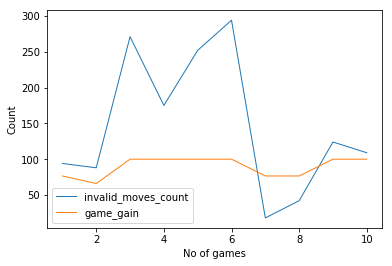

In [8]:
import matplotlib.pyplot as plt
plt.xlabel('No of games')
plt.ylabel('Count')
plt.plot(x, n_invalid_moves_count, linewidth=1, label="invalid_moves_count")
plt.plot(x, n_game_gains, linewidth=1, label="game_gain")
plt.legend(loc="bottom right")
plt.show()